<a href="https://colab.research.google.com/github/Covpet/ENHANCING-PLANT-DISEASE-DETECTION-WITH-DEEP-LEARNING-MODELS/blob/main/plant_disease_detection_(cassava_and_maize).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2

import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import pandas as pd
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Displaying images from folder: fall armyworm


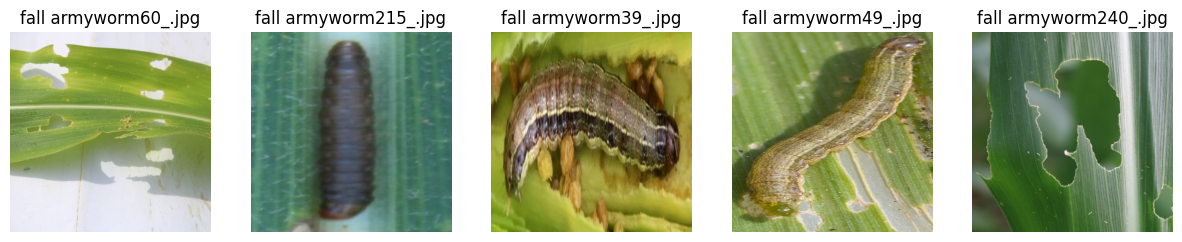

Displaying images from folder: grasshoper


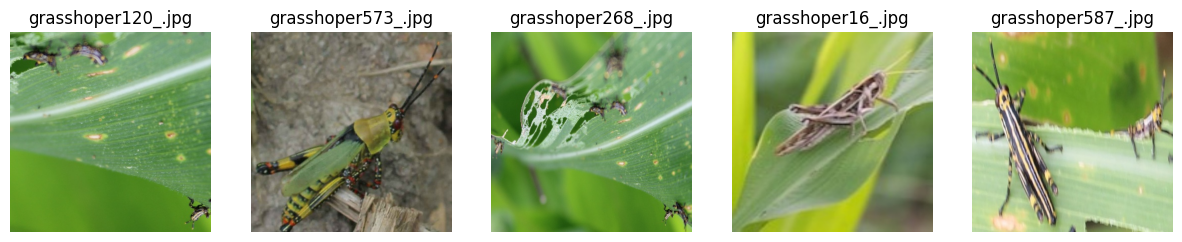

Displaying images from folder: healthy


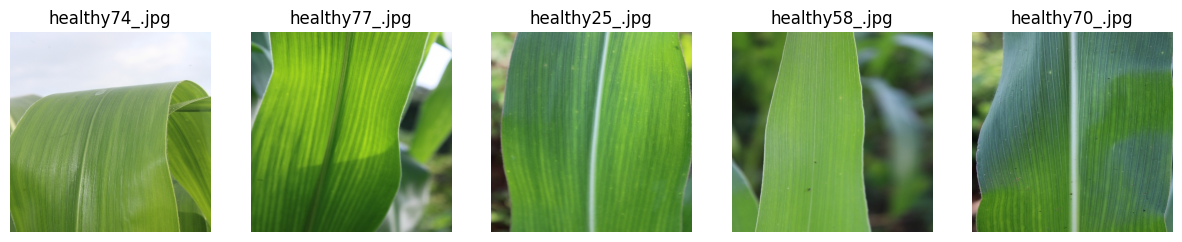

Displaying images from folder: leaf beetle


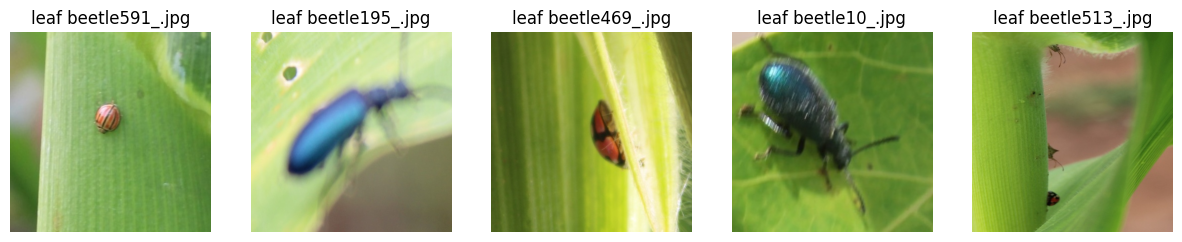

Displaying images from folder: leaf blight


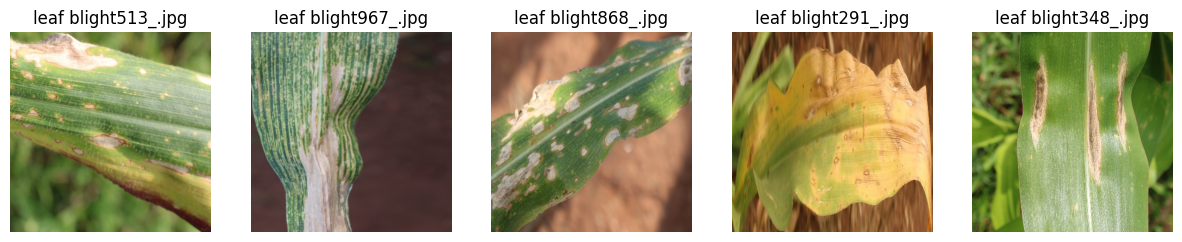

Displaying images from folder: leaf spot


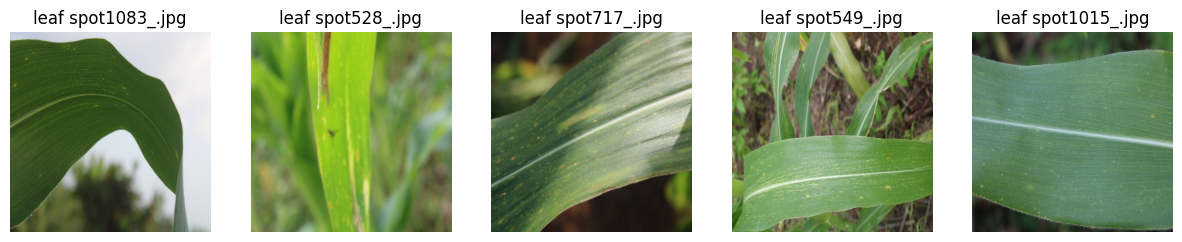

Displaying images from folder: streak virus


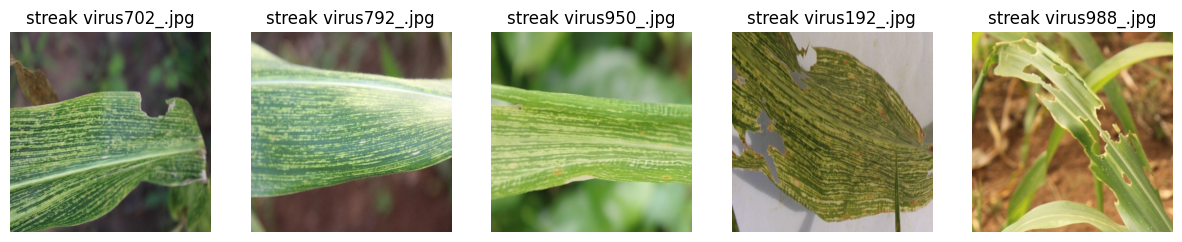

In [3]:
# Define base directory and folder names
base_dir = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Maize'
folders = ['fall armyworm', 'grasshoper', 'healthy', 'leaf beetle', 'leaf blight', 'leaf spot', 'streak virus']

# Function to check if a file is a valid image
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify if the file is a valid image
        return True
    except (IOError, SyntaxError) as e:
        return False

# Function to remove invalid image files
def remove_invalid_images(folder_path):
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        if not is_valid_image(file_path):
            print(f"Removing invalid file: {file}")
            os.remove(file_path)

# Function to display a sample of 5 images from each folder
def display_images_from_folders(base_dir, folders, num_images=5):
    for folder in folders:
        folder_path = os.path.join(base_dir, folder)
        print(f"Displaying images from folder: {folder}")

        # Remove invalid images before displaying
        remove_invalid_images(folder_path)

        # Get all valid image files in the folder after cleanup
        files = [f for f in os.listdir(folder_path) if is_valid_image(os.path.join(folder_path, f))]

        if len(files) < num_images:
            print(f"Not enough valid images in {folder}. Found only {len(files)} valid images.")
            continue

        # Randomly select images to display
        selected_files = random.sample(files, num_images)

        # Create a subplot to display images
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

        for i, file in enumerate(selected_files):
            img_path = os.path.join(folder_path, file)
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(file)

        plt.show()

# Call the function to display images and remove invalid ones
display_images_from_folders(base_dir, folders)

                                          image_path             class
0  /content/drive/MyDrive/Raw Data/CCMT Dataset/C...  bacterial blight
1  /content/drive/MyDrive/Raw Data/CCMT Dataset/C...  bacterial blight
2  /content/drive/MyDrive/Raw Data/CCMT Dataset/C...  bacterial blight
3  /content/drive/MyDrive/Raw Data/CCMT Dataset/C...  bacterial blight
4  /content/drive/MyDrive/Raw Data/CCMT Dataset/C...  bacterial blight


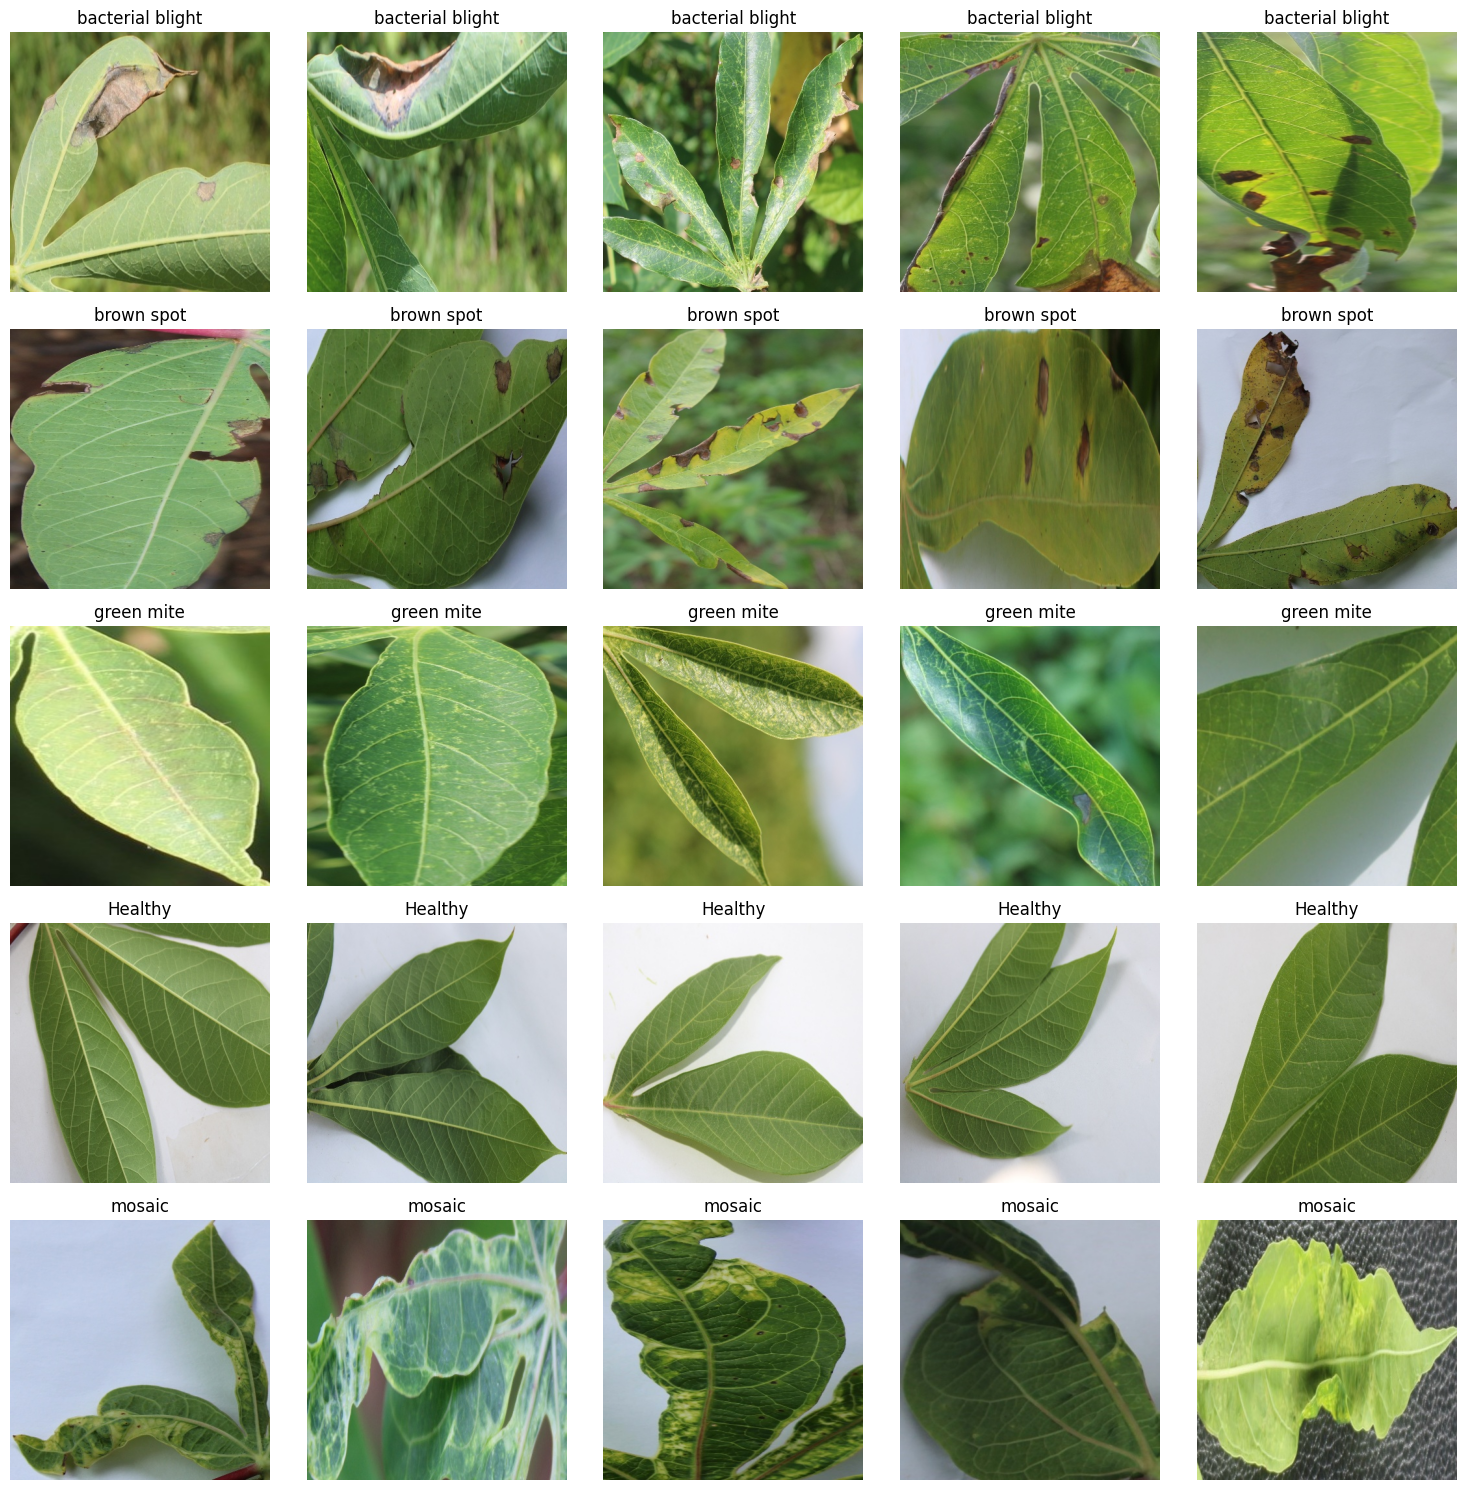

In [4]:
# Directory structure
base_dir = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Cassava'
folders = [
    'bacterial blight', 'brown spot', 'green mite', 'Healthy', 'mosaic']

# List to store image paths and their corresponding classes
image_paths = []
image_classes = []

# Iterate through each folder and collect image paths
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Adjust if necessary for different image formats
            image_paths.append(os.path.join(folder_path, filename))
            image_classes.append(folder)

# Create a DataFrame
df_images = pd.DataFrame({
    'image_path': image_paths,
    'class': image_classes
})

# Show the DataFrame with image paths and their classes
print(df_images.head())

# Set up a plot to display the images
num_images_per_class = 5  # Show 5 images per class
fig, axes = plt.subplots(nrows=len(folders), ncols=num_images_per_class, figsize=(15, 15))

# Loop through each class and display 5 images
for i, folder in enumerate(folders):
    # Filter images of the current class
    class_images = df_images[df_images['class'] == folder].head(num_images_per_class)

    for j, (image_path, label) in enumerate(zip(class_images['image_path'], class_images['class'])):
        img = Image.open(image_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(label)

plt.tight_layout()
plt.show()

In [5]:
# Function to load and prepare the DataFrame
def load_data(base_dir, folders):
    image_paths = []
    image_classes = []

    # Iterate through each folder and collect image paths
    for folder in folders:
        folder_path = os.path.join(base_dir, folder)
        for filename in os.listdir(folder_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Adjust if necessary for different image formats
                image_paths.append(os.path.join(folder_path, filename))
                image_classes.append(folder)

    # Create a DataFrame
    df_images = pd.DataFrame({
        'image_path': image_paths,
        'class': image_classes
    })

    return df_images

In [6]:
# Function to load and prepare the DataFrame
def load_data(base_dir, folders):
    image_paths = []
    image_classes = []

    # Iterate through each folder and collect image paths
    for folder in folders:
        folder_path = os.path.join(base_dir, folder)
        for filename in os.listdir(folder_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Adjust if necessary for different image formats
                image_paths.append(os.path.join(folder_path, filename))
                image_classes.append(folder)

    # Create a DataFrame
    df_images = pd.DataFrame({
        'image_path': image_paths,
        'class': image_classes
    })

    return df_images

# For Maize
base_dir_maize = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Maize'
folders_maize = [
    'fall armyworm', 'grasshoper', 'healthy', 'leaf beetle', 'leaf blight', 'leaf spot', 'streak virus'
]

df_maize = load_data(base_dir_maize, folders_maize)

# For Cassava
base_dir_cassava = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Cassava'
folders_cassava = [
    'bacterial blight', 'brown spot', 'green mite', 'Healthy', 'mosaic'
]

df_cassava = load_data(base_dir_cassava, folders_cassava)

# Count the number of images per class
maize_class_counts = df_maize['class'].value_counts()
cassava_class_counts = df_cassava['class'].value_counts()

# Count the file formats for both datasets
maize_file_formats = df_maize['image_path'].apply(lambda x: x.split('.')[-1]).value_counts()
cassava_file_formats = df_cassava['image_path'].apply(lambda x: x.split('.')[-1]).value_counts()

# Display counts for Maize
print("Maize Class Counts:")
print(maize_class_counts)
print("\nMaize File Format Counts:")
print(maize_file_formats)

# Display counts for Cassava
print("\nCassava Class Counts:")
print(cassava_class_counts)
print("\nCassava File Format Counts:")
print(cassava_file_formats)

Maize Class Counts:
class
leaf spot        1249
streak virus     1002
leaf blight       998
leaf beetle       938
grasshoper        683
fall armyworm     285
healthy           206
Name: count, dtype: int64

Maize File Format Counts:
image_path
jpg    5361
Name: count, dtype: int64

Cassava Class Counts:
class
bacterial blight    2772
brown spot          1506
Healthy             1283
mosaic              1235
green mite          1154
Name: count, dtype: int64

Cassava File Format Counts:
image_path
jpg    7950
Name: count, dtype: int64


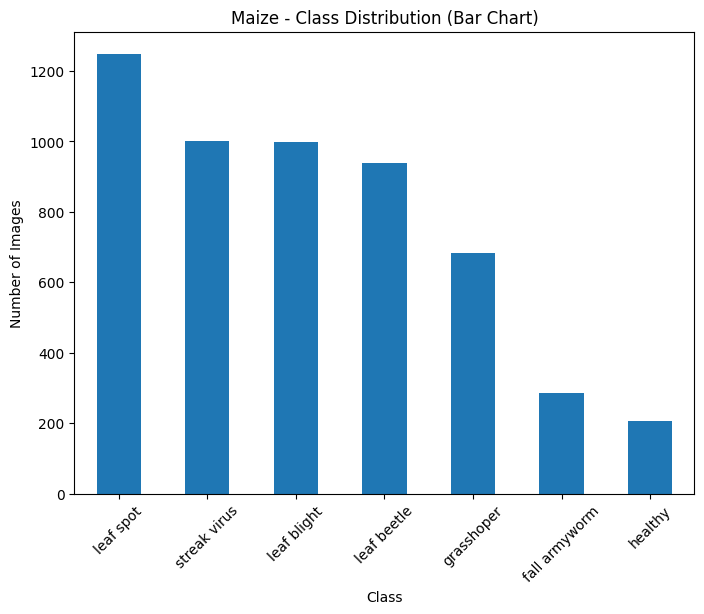

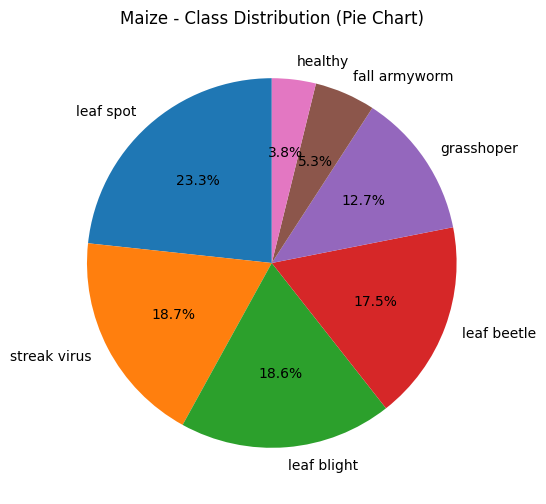

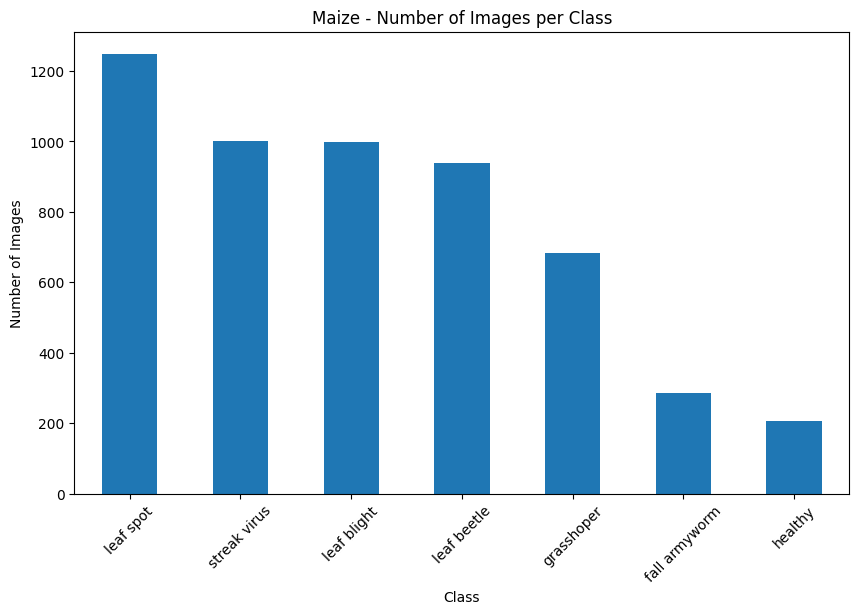

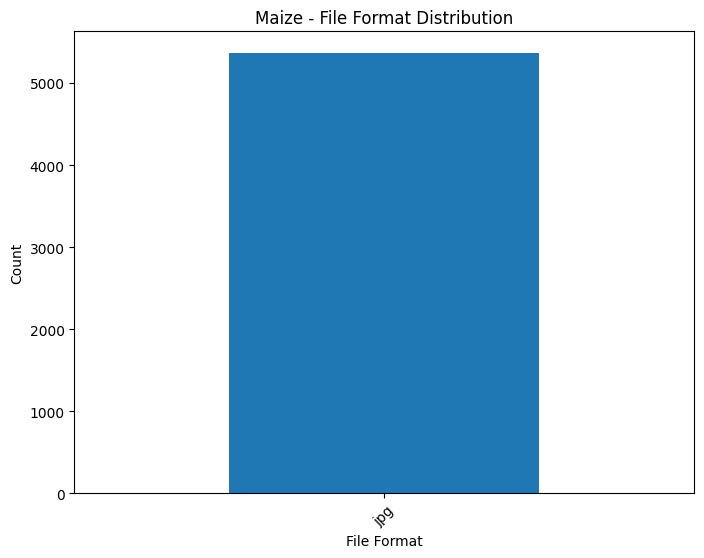

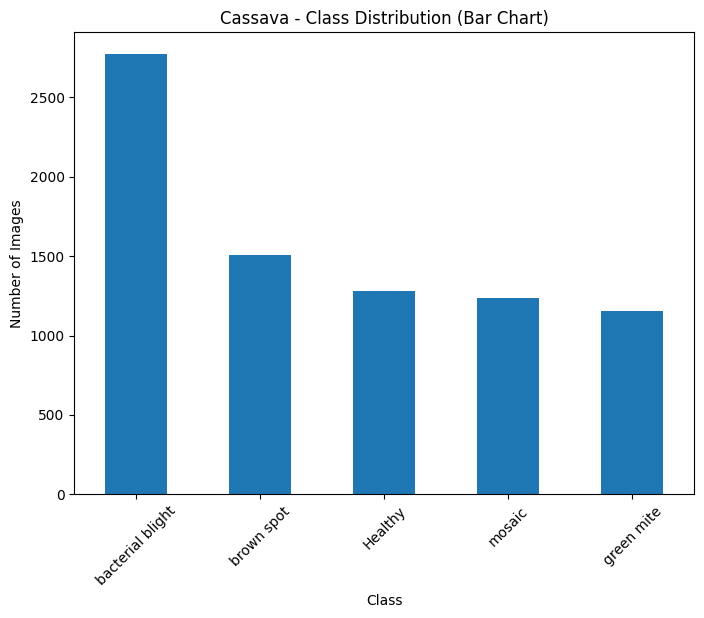

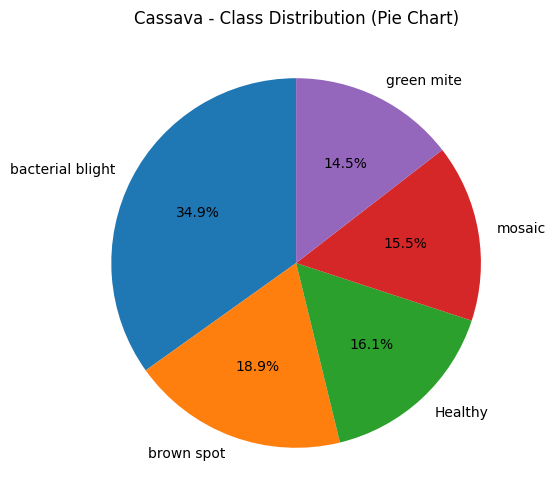

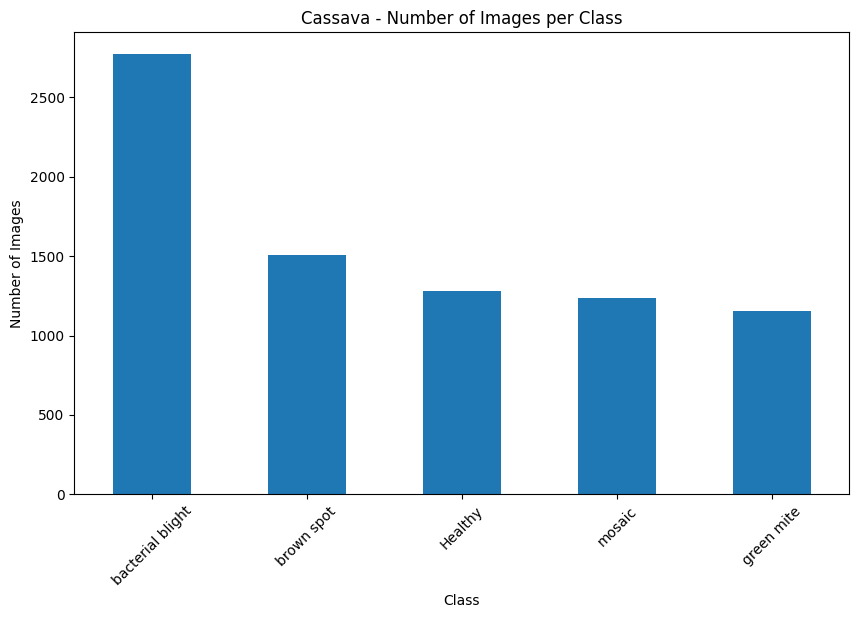

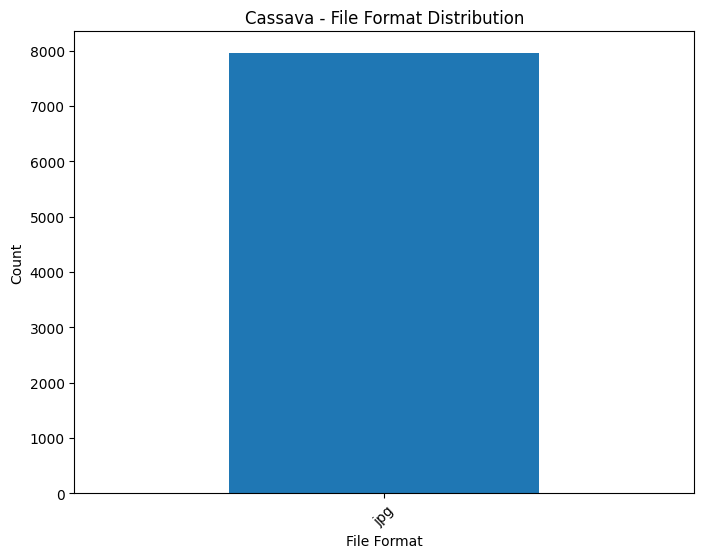

In [7]:
# For Maize
base_dir_maize = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Maize'
folders_maize = [
    'fall armyworm', 'grasshoper', 'healthy', 'leaf beetle', 'leaf blight', 'leaf spot', 'streak virus'
]

df_maize = load_data(base_dir_maize, folders_maize)

# For Cassava
base_dir_cassava = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Cassava'
folders_cassava = [
    'bacterial blight', 'brown spot', 'green mite', 'Healthy', 'mosaic'
]

df_cassava = load_data(base_dir_cassava, folders_cassava)

# EDA for Maize dataset
def plot_eda(df_images, title):
    # Class distribution (Bar Chart)
    plt.figure(figsize=(8, 6))
    df_images['class'].value_counts().plot(kind='bar')
    plt.title(f'{title} - Class Distribution (Bar Chart)')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

    # Class distribution (Pie Chart)
    plt.figure(figsize=(8, 6))
    df_images['class'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title(f'{title} - Class Distribution (Pie Chart)')
    plt.ylabel('')
    plt.show()

    # Number of Images per Class (Bar Chart)
    class_counts = df_images['class'].value_counts()
    class_counts.plot(kind='bar', figsize=(10, 6))
    plt.title(f'{title} - Number of Images per Class')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

    # File Format Distribution (Bar Chart)
    file_formats = df_images['image_path'].apply(lambda x: x.split('.')[-1]).value_counts()
    file_formats.plot(kind='bar', figsize=(8, 6))
    plt.title(f'{title} - File Format Distribution')
    plt.xlabel('File Format')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Plot EDA for Maize dataset
plot_eda(df_maize, 'Maize')

# Plot EDA for Cassava dataset
plot_eda(df_cassava, 'Cassava')

In [8]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

                                          image_path                class
0  /content/drive/MyDrive/Raw Data/CCMT Dataset/M...  maize_fall armyworm
1  /content/drive/MyDrive/Raw Data/CCMT Dataset/M...  maize_fall armyworm
2  /content/drive/MyDrive/Raw Data/CCMT Dataset/M...  maize_fall armyworm
3  /content/drive/MyDrive/Raw Data/CCMT Dataset/M...  maize_fall armyworm
4  /content/drive/MyDrive/Raw Data/CCMT Dataset/M...  maize_fall armyworm


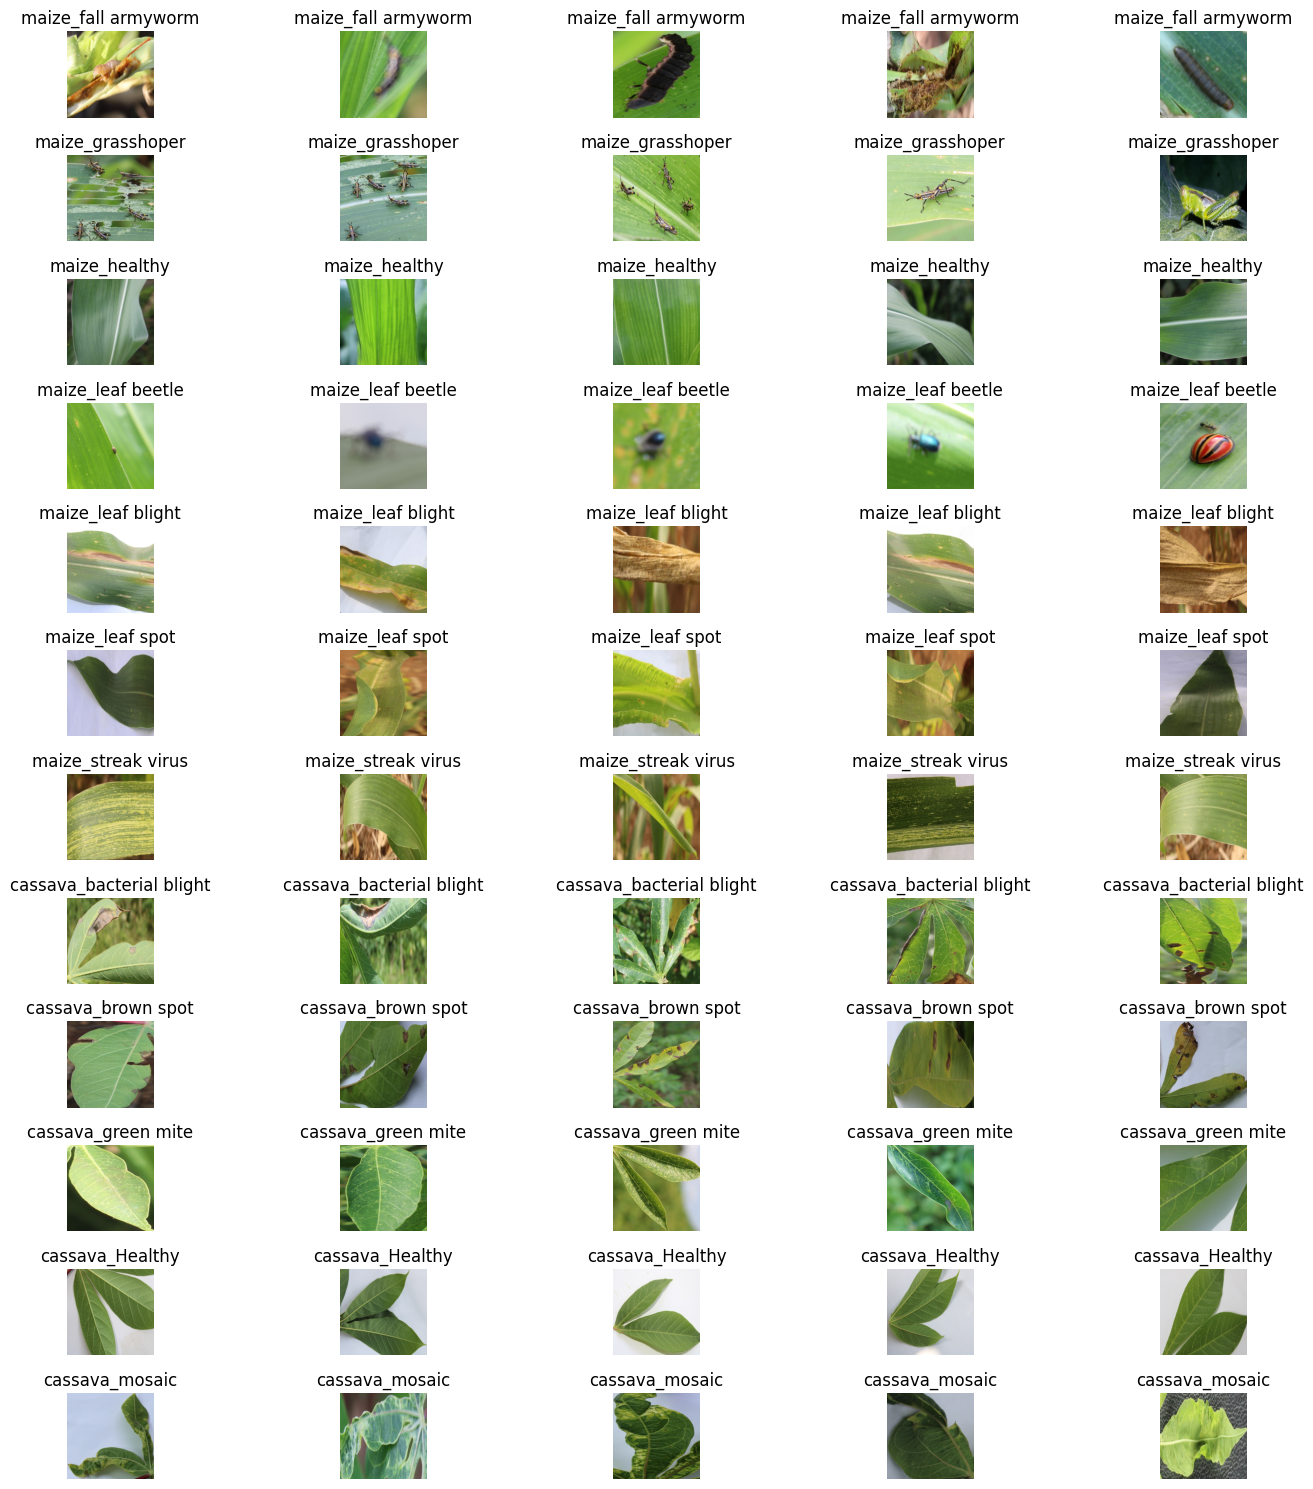

In [9]:
# Define base directories for both datasets
maize_base_dir = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Maize'
cassava_base_dir = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Cassava'

# Folder names for Maize dataset
maize_folders = ['fall armyworm', 'grasshoper', 'healthy', 'leaf beetle', 'leaf blight', 'leaf spot', 'streak virus']

# Folder names for Cassava dataset
cassava_folders = ['bacterial blight', 'brown spot', 'green mite', 'Healthy', 'mosaic']

# Function to check if a file is a valid image
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify if the file is a valid image
        return True
    except (IOError, SyntaxError) as e:
        return False

# Function to remove invalid image files
def remove_invalid_images(folder_path):
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        if not is_valid_image(file_path):
            print(f"Removing invalid file: {file}")
            os.remove(file_path)

# Remove invalid images before training for both datasets
for folder in maize_folders:
    remove_invalid_images(os.path.join(maize_base_dir, folder))
for folder in cassava_folders:
    remove_invalid_images(os.path.join(cassava_base_dir, folder))

# Create a DataFrame for the images in both datasets
image_paths = []
image_classes = []

# Maize dataset
for folder in maize_folders:
    folder_path = os.path.join(maize_base_dir, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(folder_path, filename))
            image_classes.append(f"maize_{folder}")

# Cassava dataset
for folder in cassava_folders:
    folder_path = os.path.join(cassava_base_dir, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(folder_path, filename))
            image_classes.append(f"cassava_{folder}")

# Create a DataFrame
df_images = pd.DataFrame({
    'image_path': image_paths,
    'class': image_classes
})

# Show the DataFrame with image paths and their classes
print(df_images.head())

# Set up a plot to display the images
num_images_per_class = 5  # Show 5 images per class
fig, axes = plt.subplots(nrows=len(maize_folders) + len(cassava_folders), ncols=num_images_per_class, figsize=(15, 15))

# Loop through each class and display 5 images
for i, folder in enumerate(maize_folders + cassava_folders):
    # Filter images of the current class
    class_images = df_images[df_images['class'].str.contains(folder)].head(num_images_per_class)

    for j, (image_path, label) in enumerate(zip(class_images['image_path'], class_images['class'])):
        img = Image.open(image_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(label)

plt.tight_layout()
plt.show()

In [10]:
unique_classes = df_images['class'].nunique()
print(f"Number of classes in the dataset: {unique_classes}")

Number of classes in the dataset: 12


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Combine the Maize and Cassava DataFrames
df_combined = pd.concat([df_maize, df_cassava], ignore_index=True)

# Split into training (80%), testing (10%), and validation (10%)
train_df, test_df = train_test_split(df_combined, test_size=0.2, stratify=df_combined['class'], random_state=42)
valid_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['class'], random_state=42)

# Display the counts for each dataset to verify
print(f"Training set: {train_df.shape[0]} images")
print(f"Validation set: {valid_df.shape[0]} images")
print(f"Testing set: {test_df.shape[0]} images")

# Optional: Check the distribution of classes in each set
print("\nTraining set class distribution:")
print(train_df['class'].value_counts())

print("\nValidation set class distribution:")
print(valid_df['class'].value_counts())

print("\nTesting set class distribution:")
print(test_df['class'].value_counts())

Training set: 10648 images
Validation set: 1331 images
Testing set: 1332 images

Training set class distribution:
class
bacterial blight    2218
brown spot          1205
Healthy             1026
leaf spot            999
mosaic               988
green mite           923
streak virus         802
leaf blight          798
leaf beetle          750
grasshoper           546
fall armyworm        228
healthy              165
Name: count, dtype: int64

Validation set class distribution:
class
bacterial blight    277
brown spot          150
Healthy             128
leaf spot           125
mosaic              123
green mite          115
leaf blight         100
streak virus        100
leaf beetle          94
grasshoper           69
fall armyworm        29
healthy              21
Name: count, dtype: int64

Testing set class distribution:
class
bacterial blight    277
brown spot          151
Healthy             129
leaf spot           125
mosaic              124
green mite          116
leaf blight    

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Data generators to load and augment images in batches
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Assuming you have a function `flow_from_dataframe()` to load images from the DataFrame
# If your DataFrame contains the image paths and classes, you can use it in ImageDataGenerator.
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, directory=None,
                                                    x_col='image_path', y_col='class',
                                                    target_size=(150, 150), batch_size=32,
                                                    class_mode='categorical')

valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid_df, directory=None,
                                                    x_col='image_path', y_col='class',
                                                    target_size=(150, 150), batch_size=32,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, directory=None,
                                                  x_col='image_path', y_col='class',
                                                  target_size=(150, 150), batch_size=32,
                                                  class_mode='categorical')

# Build the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_df['class'].unique()), activation='softmax')  # Number of classes
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define a checkpoint to save the best model during training
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=valid_generator,
                    callbacks=[checkpoint])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

Found 10648 validated image filenames belonging to 12 classes.
Found 1331 validated image filenames belonging to 12 classes.
Found 1332 validated image filenames belonging to 12 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.2171 - loss: 2.3106
Epoch 1: val_loss improved from inf to 1.77542, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 150s 446ms/step - accuracy: 0.2172 - loss: 2.3103 - val_accuracy: 0.3569 - val_loss: 1.7754
Epoch 2/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.3377 - loss: 1.8716
Epoch 2: val_loss improved from 1.77542 to 1.54394, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 151s 453ms/step - accuracy: 0.3378 - loss: 1.8714 - val_accuracy: 0.4553 - val_loss: 1.5439
Epoch 3/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.4250 - loss: 1.6262
Epoch 3: val_loss improved from 1.54394 to 1.29404, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 166s 498ms/step - accuracy: 0.4250 - loss: 1.6261 - val_accuracy: 0.5327 - val_loss: 1.2940
Epoch 4/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.4979 - loss: 1.4232
Epoch 4: val_loss improved from 1.29404 to 1.20920, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 159s 476ms/step - accuracy: 0.4979 - loss: 1.4231 - val_accuracy: 0.5838 - val_loss: 1.2092
Epoch 5/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.5387 - loss: 1.3281
Epoch 5: val_loss improved from 1.20920 to 1.18301, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 153s 458ms/step - accuracy: 0.5387 - loss: 1.3280 - val_accuracy: 0.5875 - val_loss: 1.1830
Epoch 6/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.5586 - loss: 1.2742
Epoch 6: val_loss improved from 1.18301 to 1.00216, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 154s 463ms/step - accuracy: 0.5586 - loss: 1.2741 - val_accuracy: 0.6597 - val_loss: 1.0022
Epoch 7/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.5981 - loss: 1.1311
Epoch 7: val_loss improved from 1.00216 to 0.96128, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 162s 487ms/step - accuracy: 0.5981 - loss: 1.1311 - val_accuracy: 0.6679 - val_loss: 0.9613
Epoch 8/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.6216 - loss: 1.0926
Epoch 8: val_loss did not improve from 0.96128
333/333 ━━━━━━━━━━━━━━━━━━━━ 167s 501ms/step - accuracy: 0.6216 - loss: 1.0926 - val_accuracy: 0.6612 - val_loss: 1.0037
Epoch 9/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.6339 - loss: 1.0417
Epoch 9: val_loss improved from 0.96128 to 0.81082, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 151s 452ms/step - accuracy: 0.6339 - loss: 1.0417 - val_accuracy: 0.7047 - val_loss: 0.8108
Epoch 10/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.6485 - loss: 0.9782
Epoch 10: val_loss improved from 0.81082 to 0.79796, saving model to best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 146s 438ms/step - accuracy: 0.6485 - loss: 0.9782 - val_accuracy: 0.7137 - val_loss: 0.7980
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.7405 - loss: 0.7814
Test accuracy: 0.7327


In [13]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

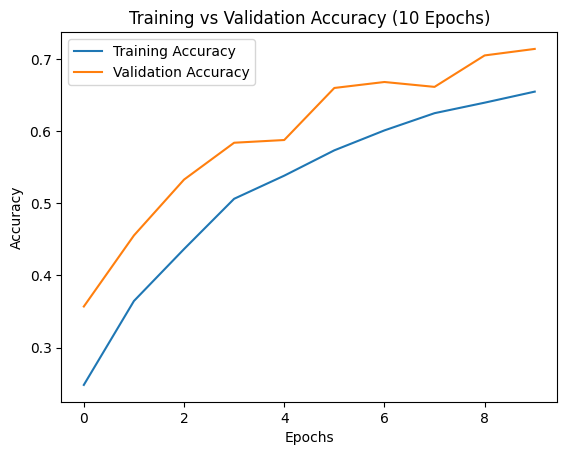

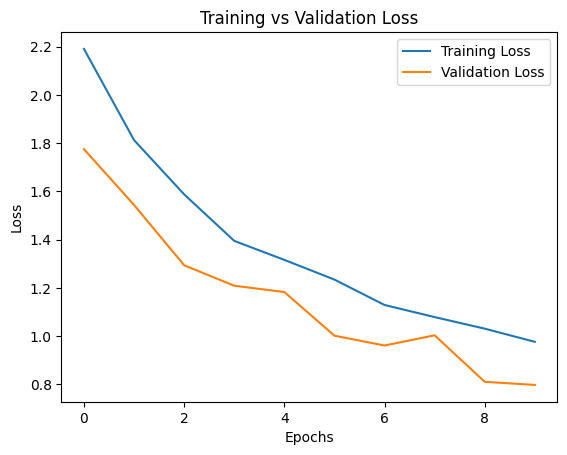

In [14]:
# Plot the training and validation accuracy fo 10 Epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (10 Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step
Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.10      0.10      0.10       129
bacterial blight       0.21      0.24      0.22       277
      brown spot       0.12      0.13      0.13       151
   fall armyworm       0.00      0.00      0.00        28
      grasshoper       0.08      0.10      0.09        68
      green mite       0.10      0.09      0.10       116
         healthy       0.00      0.00      0.00        20
     leaf beetle       0.15      0.15      0.15        94
     leaf blight       0.11      0.11      0.11       100
       leaf spot       0.10      0.10      0.10       125
          mosaic       0.09      0.07      0.08       124
    streak virus       0.07      0.07      0.07       100

        accuracy                           0.13      1332
       macro avg       0.09      0.10      0.10      1332
    weighted avg       0.12      0.13      0.12      1332



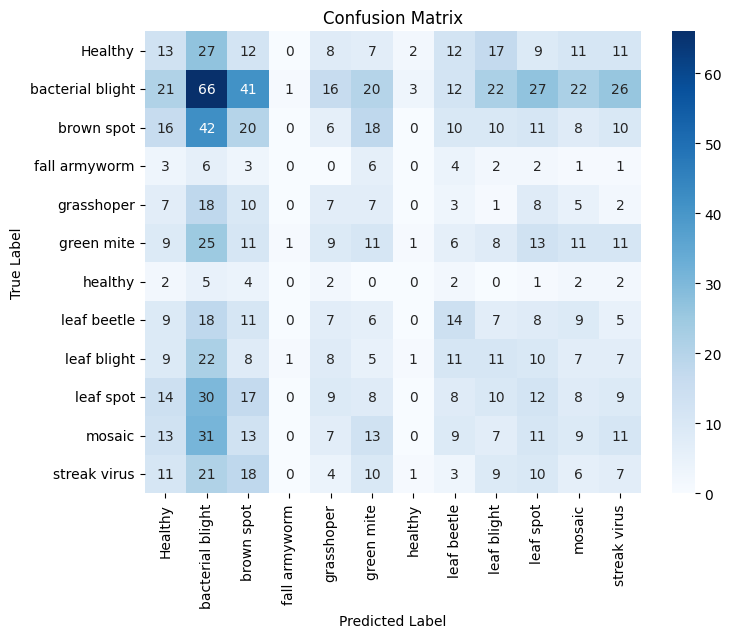

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Class labels

# Predict on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()